# Домашнее задание 3. Алгоритмы кластеризации

*** Автор --- Ракитин Виталий, BD-11 ***

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import os
import pickle
# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [3]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры  - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("v.rakitin") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`.

Для начала вспомним, что же это за расстояния такие (в качестве нормы будем использовать Евклидову)

1. Single-linkage

$$d_{\min} (C_i,C_j) = \min\limits_{{\bf x} \in C_i, {\bf y} \in C_j} ||{\bf x} - {\bf y}||$$

2. Complete-linkage

$$d_{\max} (C_i,C_j) = \max\limits_{{\bf x} \in C_i, {\bf y} \in C_j} ||{\bf x} - {\bf y}||$$

3. Average

$$d_{avg} (C_i,C_j) = \frac{1}{n_j n_i} \sum\limits_{{\bf x} \in C_i}  \sum\limits_{{\bf y} \in C_j} ||{\bf x} - {\bf y}||$$



In [226]:

# Aglomerative Hierarchical clustering 

class Clustering:
    """
    Implement clustering algorithm according 
    """
    
    
    def __init__(self, k=2, linkage="single"):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.linkname = linkage
        self.linkage = {"single":self.single,
                        "complete":self.complete,
                        "average":self.average}[linkage]
        self.k = k
        return
    
    def Dist(self, a,b):
        # подразумевается, что a и b изначально одинаковой длинны
        summ = 0.0
        for i in xrange(len(a)):
            summ += abs(a[i] - b[i])
        return summ
            
    def single(self, A, B):
        minimum = inf
        for a in A:
            for b in B:
                d = self.Dist(a,b)
                if d < minimum: minimum = d
        return minimum
    
    def complete(self, A, B): 
        maximum = 0.0
        for a in A:
            for b in B:
                d = self.Dist(a,b)
                if d > maximum: maximum = d
        return maximum
    
        
    def average(self, A, B):
        summa = 0.0
        for a in A:
            for b in B:
                summa += self.Dist(a,b)
        return summa/(len(A)*len(B))
    

    
    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.N_objects  = len(x) # всего объектов
        self.N_clusters = self.N_objects 
        # всего кластеров в начальный момент столько же, сколько объектов
        
        # уникальное название файла  
        self.tmp_file = "tmp_%s_%i_%0.2lf"%(self.linkname,len(x),x[0][0])
        
        # сами кластера: в начальный момент времени каждый объект -- кластер
        self.Clusters = [{tuple(obj)} for obj in x] 
        
        self.prev_k = inf
        self.clust = []
        self.tree = []
        if os.path.exists(self.tmp_file):
            with open(self.tmp_file, 'rb') as f:
                data = pickle.load(f)
                self.prev_k = data["k"]
                self.clust = data["clust"]
                self.tree = data["tree"]
                counter = 0
                for i,c in enumerate(data["clust"]):
                    if c >= self.k:
                        self.Clusters[data["tree"][i][0]].update(self.Clusters[data["tree"][i][1]])
                        B = self.Clusters[data["tree"][i][1]]
                        self.Clusters.remove(B)
                        self.N_clusters -= 1
                        counter += 1
                    else:
                        break
                        
        # зададим матрицу расстояний и посчитаем её в начальный момент 
        # (треугольная, на остлальных будут inf)
        # если количество кластеров уже k, то она не нужна!
        if self.N_clusters > self.k:
            self.distanse = np.full((self.N_clusters,self.N_clusters),inf)
            for C in self.Clusters:
                self.change_distance_after(C)

        return self
    
    
    def change_distance_after(self, cluster):
        cluster_number = self.Clusters.index(cluster)
        for i in xrange(cluster_number+1,self.N_clusters):
            self.distanse[cluster_number][i] = self.linkage(self.Clusters[i],cluster)
        return self
    
    def count_distance_to_new_cluster(self, x, y):
        dist = []
        for i in xrange(x):
            self.distanse[i][x] = min(self.distanse[i][x], self.distanse[i][y])
        for i in xrange(x+1,y):
            self.distanse[x][i] = min(self.distanse[x][i], self.distanse[i][y])
        for i in xrange(y,self.N_clusters):
            self.distanse[x][i] = min(self.distanse[x][i], self.distanse[y][i])
        return dist
            
            
    def merge(self, x,y):
        min_x,max_x = min(x,y), max(x,y)
        A = self.Clusters[min_x]
        B = self.Clusters[max_x]
        
        self.Clusters[min_x].update(self.Clusters[max_x])
        self.count_distance_to_new_cluster(min_x,max_x)
        
        # Вычеркнем все строки, содержащие B'
        self.Clusters.remove(B)
        self.N_clusters -= 1
        self.distanse = delete(self.distanse, max_x, 0)
        self.distanse = delete(self.distanse, max_x, 1)
        return min_x,max_x
        
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        
        while self.N_clusters > self.k:
            A = B = None
            mindist = inf
            # находим координаты минимального расстояния между кластерами
            min_x,min_y = divmod(self.distanse.argmin(), self.distanse.shape[1]) 
            min_x,min_y = self.merge(min_x,min_y)
            self.tree.append((min_x,min_y))
            self.clust.append(self.N_clusters)
            
        if self.k < self.prev_k:
            full_dict ={"k":self.k, "tree":self.tree, "clust":self.clust }    
            with open(self.tmp_file, "w") as f: 
                pickle.dump(full_dict,f)
            print "The tree is saved\n\n"
            
        cluster_index = []
        for obj in x:
            for i,C in enumerate(self.Clusters):
                if tuple(obj) in C:
                    cluster_index.append(i)
                    break
        return cluster_index
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


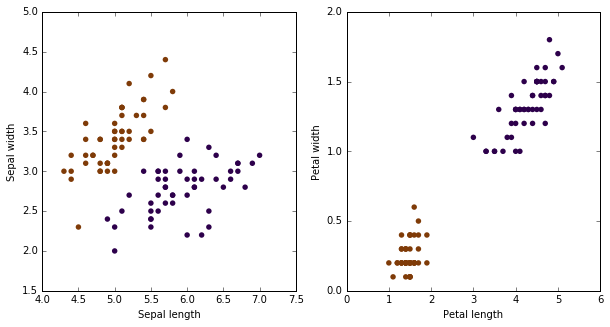

In [4]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]
print y_iris

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [163]:
pred_iris = Clustering(2,"average").fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [111]:
def Dist(a,b):
    # подразумевается, что a и b изначально одинаковой длинны
    summ = 0.0
    for i in xrange(len(a)):
        summ += abs(a[i] - b[i])
    return summ

def Sihouette(x, y):
    """
    Implement quality criterion of your choice
    """
    length = len(y)
    clusters = {} # все кластеры, которые уже мелькали
    for elem in y:
        if elem not in clusters: #если такого кластера ещё не было, то добавим в clusters
            clusters[elem] = 1
        else:
            clusters[elem] += 1 
    K = len(clusters)#количество кластеров
    
    #введём матрицы a и b для нашего критерия (K x N)
    #a --- сумма растояний до всех элементов кластера, в котором находится текущая точка
    #b --- сумма растояний до каждого кластера по отдельности.
    a = [0 for p in xrange(length)]
    b = [{} for p in xrange(length)]
    
    for i,elem in enumerate(y):
        if clusters[elem] > 10: #отсекаем выбросы
            for j,clust_elem in enumerate(y):
                if clusters[clust_elem] > 10 and i != j: #отсекаем выбросы
                    if elem == clust_elem:
                        a[i] += Dist(x[i],x[j])/(clusters[clust_elem]-1)
                    else:
                        if clust_elem in b[i]:
                            b[i][clust_elem] += Dist(x[i],x[j]) /(clusters[clust_elem])
                        else:
                            b[i][clust_elem]  = Dist(x[i],x[j])/(clusters[clust_elem])
              
    #теперь нормируем a и b
    #a1 --- среднеие растояния до точек соответствующего кластера
    #b1 --- среднее растояние до соседнего(!) кластера, т.е. минимальное из всех растояний
    a1 = [0 for p in xrange(len(y))]
    b1 = [0 for p in xrange(len(y))]
            
    for i,elem in enumerate(y):
        if clusters[elem] > 10:
            a1[i] = a[i]
            # а если <10, то это вообще выброс -- нам он до лампочки
            min_c = inf
            for c in b[i]:
                if min_c > b[i][c]: min_c = b[i][c]
            if min_c != inf:
                b1[i] = min_c
                
      
    # S --- ключевой параметр критерия
    S = 0.0
    lenn = 0
    for elem in xrange(length):
        if b1[elem] != 0 or a1[elem] != 0:
            if b1[elem] > a1[elem]:
                S += (b1[elem] - a1[elem])/b1[elem]
            else:
                S += (b1[elem] - a1[elem])/a1[elem]
            lenn += 1
    if lenn != 0:
        S = S/lenn
    else:
        S = -1.0
    return S

print Sihouette(x_iris,pred_iris) 
quality = Sihouette

0.73839626695


Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

In [175]:
def Create_test_sample(x, length = 300):
    new_x = []
    test_numbers = np.random.choice(range(len(x)),length)
    for i in test_numbers:
        new_x.append(x[i])
    return np.array(new_x)

x_sample = Create_test_sample(x,1000)

In [177]:
ks = range(2, 1000, 50)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(k,"single")
    y = cls.fit_predict(x_sample)
    criteria[i] = quality(x_sample, y)
    print criteria[i], k
    

The tree is saved


-1.0 2
-1.0 52
-0.00224866053253 102
-1.0 152
0.0319745883683 202
0.0617374055713 252
0.0590785382272 302
-0.00830883392262 352
-0.0316265991351 402
-0.0655586634953 452
-0.102804825601 502
-0.12760603807 552
-0.0310866673571 602
-1.0 652
-1.0 702
-1.0 752
-1.0 802
-1.0 852
-1.0 902
-1.0 952


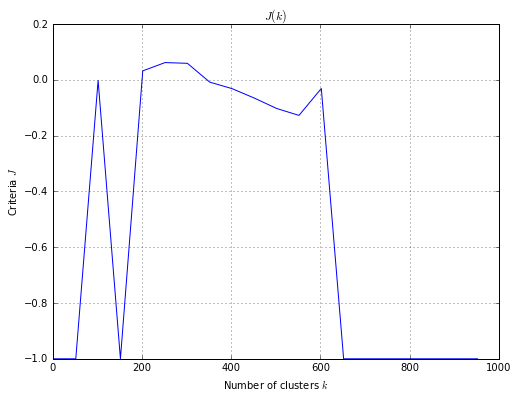

In [178]:
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Предположим, что данные во всех данных в нашей выборка распределены одинаково. Тогда идеальным количеством кластеров будет именно 1/2 от общего количества данных.

In [219]:
k = len(x)/2
cls = Clustering(k,"single")
y = cls.fit_predict(x)

Выделим только те кластеры, где количество элментов не меньше, чем 0.5% от общего числа.

In [224]:
p = {}
for i in y:
    if i in p:
        p[i] += 1
    else:
        p[i] = 1

x_clustered = []
y_clustered = []
for i in xrange(len(y)):
    if p[y[i]] < len(x)/200:
        x_clustered.append(x[i])
        y_clustered.append(y[i])

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10654
[t-SNE] Computed conditional probabilities for sample 2000 / 10654
[t-SNE] Computed conditional probabilities for sample 3000 / 10654
[t-SNE] Computed conditional probabilities for sample 4000 / 10654
[t-SNE] Computed conditional probabilities for sample 5000 / 10654
[t-SNE] Computed conditional probabilities for sample 6000 / 10654
[t-SNE] Computed conditional probabilities for sample 7000 / 10654
[t-SNE] Computed conditional probabilities for sample 8000 / 10654
[t-SNE] Computed conditional probabilities for sample 9000 / 10654
[t-SNE] Computed conditional probabilities for sample 10000 / 10654
[t-SNE] Computed conditional probabilities for sample 10654 / 10654
[t-SNE] Mean sigma: 0.071632
[t-SNE] Error after 100 iterations with early exaggeration: 1.465346
[t-SNE] Error after 275 iterations: 1.420155


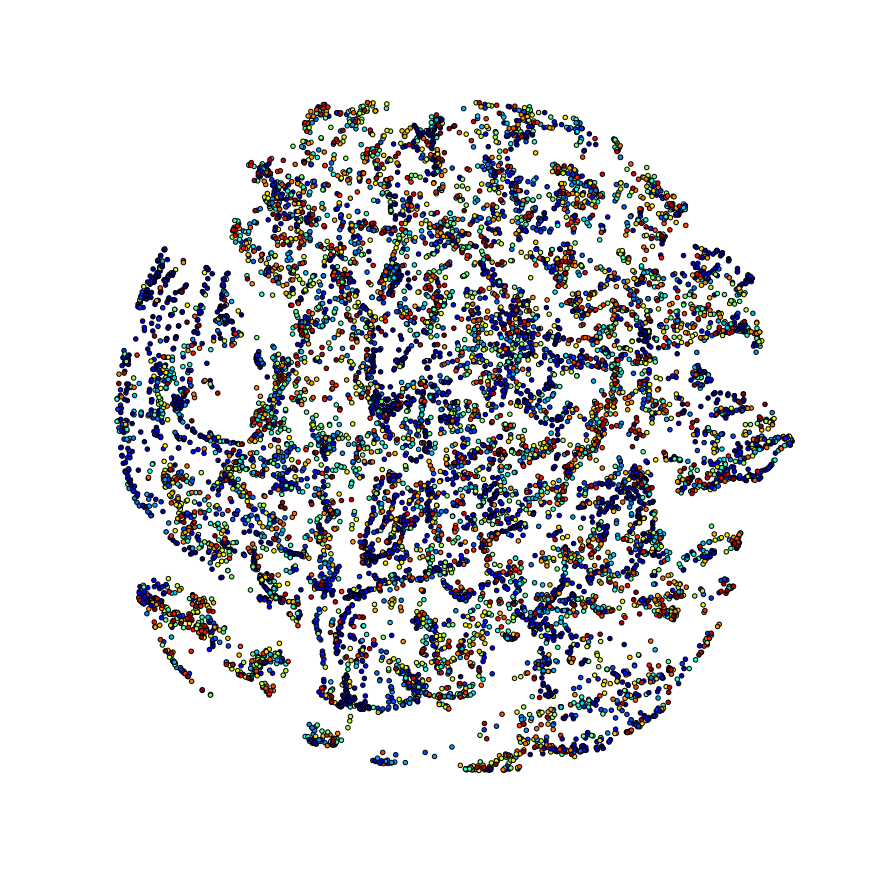

In [225]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x_clustered)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y_clustered))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

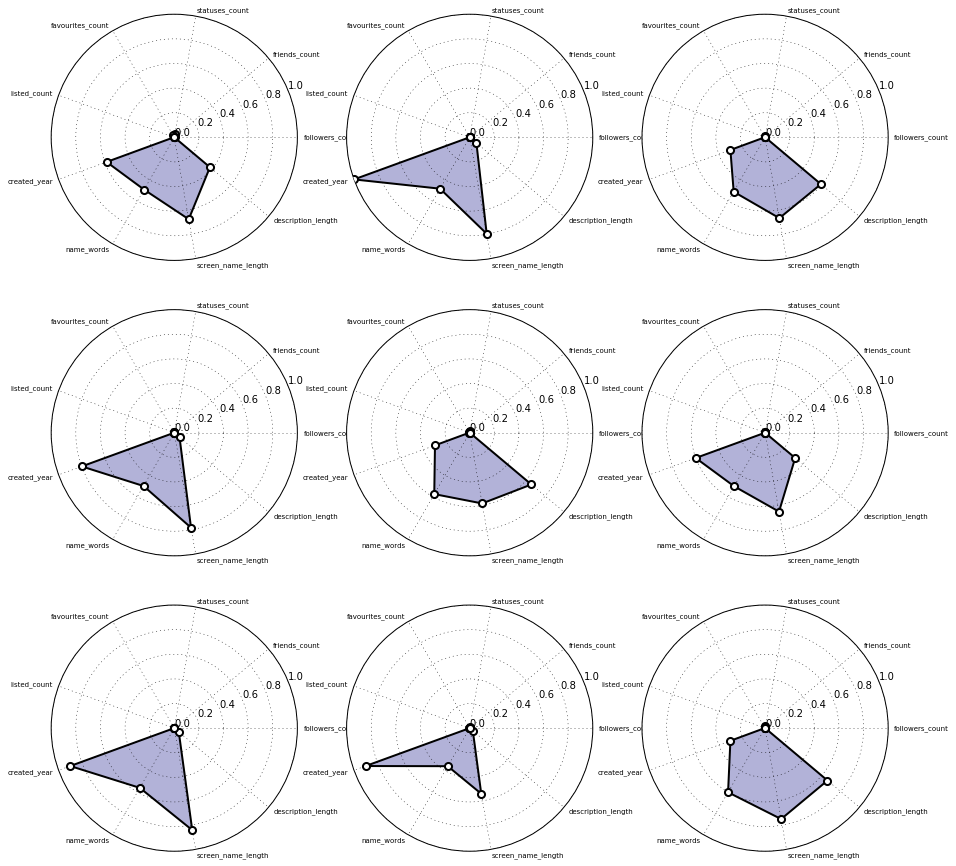

In [217]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.